Part 1: Paper-Based Data Preprocessing

**Modified to follow "Reinforcement Learning Pair Trading: A Dynamic Scaling Approach" methodology**

This part implements the research paper's pseudo-spread calculation and trading zone methodology instead of complex feature engineering:

- **Pseudo-Spread Calculation**: Price deviation from moving average with z-score normalization
- **Trading Zones**: 5 zones based on z-score thresholds (LONG/NEUTRAL_LONG/CLOSE/NEUTRAL_SHORT/SHORT)  
- **Simplified Features**: Only 3 values (Position, Z-Score, Zone) vs 32+ complex features
- **Anti-Overfitting**: Much simpler signal processing to prevent memorization

In [2]:
# Install required packages
%pip install numpy pandas matplotlib seaborn plotly scikit-learn stable-baselines3 gymnasium pyarrow ta


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:

# ===================== Paper-Based Signal Generation =====================
import os
import numpy as np
import pandas as pd
from enum import Enum

# Paper-Based Configuration (from research paper)
PATH = "../ETHUSDT_1m_with_indicators.parquet"
TS_COL = "ts"
PRICE_COL = "close"

# Signal parameters (from research paper)
MA_PERIOD = 60                 # Moving average period for pseudo-spread
WINDOW_SIZE = 120              # Window for z-score normalization  
OPEN_THRESHOLD = 2.0           # Z-score threshold to open positions
CLOSE_THRESHOLD = 0.5          # Z-score threshold to close positions

# Trading parameters (optimized from methodology)
SEED_MONEY = 10000.0
FEE_RATE = 0.0001              # Reduced from 0.0005 to enable trading
SLIPPAGE = 0.0001              # Reduced from 0.0002  
TRANSACTION_PENALTY_RATE = 0.00005  # Reduced from 0.001
ACTION_REWARD_SCALE = 0.1      # Increased from 0.01

OUTPUT_DIR = "./processed_data_paper"

print("🔬 PAPER-BASED DATA PREPROCESSING")
print("================================")
print("Following 'Reinforcement Learning Pair Trading: A Dynamic Scaling Approach'")
print(f"   MA Period: {MA_PERIOD}, Window: {WINDOW_SIZE}")
print(f"   Thresholds: Open={OPEN_THRESHOLD}, Close={CLOSE_THRESHOLD}")
print(f"   Simplified approach: 3 values vs 32+ complex features")

class TradingZone(Enum):
    """Trading zones based on z-score thresholds (from paper)"""
    LONG_ZONE = 0      # Z-score < -open_threshold (price below MA - buy signal)
    NEUTRAL_LONG = 1   # -open_threshold <= Z-score < -close_threshold  
    CLOSE_ZONE = 2     # -close_threshold <= Z-score <= close_threshold
    NEUTRAL_SHORT = 3  # close_threshold < Z-score <= open_threshold
    SHORT_ZONE = 4     # Z-score > open_threshold (price above MA - sell signal)

def calculate_pseudo_spread(prices: pd.Series, ma_period: int, window_size: int) -> pd.DataFrame:
    """Calculate pseudo-spread following research paper methodology"""
    print(f"   📊 Calculating pseudo-spread signals...")
    
    df_signals = pd.DataFrame()
    
    # Step 1: Calculate moving average (pseudo-spread baseline)
    ma = prices.rolling(window=ma_period, min_periods=1).mean()
    
    # Step 2: Calculate spread (price deviation from MA)
    spread = prices - ma
    
    # Step 3: Normalize spread using z-score over rolling window
    spread_mean = spread.rolling(window=window_size, min_periods=1).mean()
    spread_std = spread.rolling(window=window_size, min_periods=1).std()
    z_score = (spread - spread_mean) / (spread_std + 1e-8)  # Avoid division by zero
    z_score = z_score.fillna(0)  # Fill NaN with neutral value
    
    # Store signals
    df_signals['price'] = prices
    df_signals['ma'] = ma
    df_signals['spread'] = spread
    df_signals['z_score'] = z_score
    
    print(f"      Z-score range: [{z_score.min():.2f}, {z_score.max():.2f}]")
    
    return df_signals

def calculate_trading_zone(z_score: float, open_threshold: float, close_threshold: float) -> int:
    """Calculate trading zone based on z-score thresholds"""
    if z_score > open_threshold:
        return TradingZone.SHORT_ZONE.value  # Price above MA - sell signal
    elif z_score > close_threshold:
        return TradingZone.NEUTRAL_SHORT.value
    elif z_score >= -close_threshold:
        return TradingZone.CLOSE_ZONE.value  # Near MA - close positions
    elif z_score >= -open_threshold:
        return TradingZone.NEUTRAL_LONG.value
    else:
        return TradingZone.LONG_ZONE.value   # Price below MA - buy signal

# ===================== Load and Process Data =====================
print("\n📁 Loading data...")
df = pd.read_parquet(PATH)
df = df.reset_index()
df.columns = df.columns.str.strip()
df = df.sort_values(TS_COL).reset_index(drop=True)

# Clean price data
df[PRICE_COL] = pd.to_numeric(df[PRICE_COL], errors='coerce')
df = df.dropna(subset=[PRICE_COL])
df = df[df[PRICE_COL] > 0]

print(f"   Data loaded: {len(df)} rows")
print(f"   Date range: {pd.to_datetime(df[TS_COL], unit='s').min()} to {pd.to_datetime(df[TS_COL], unit='s').max()}")

# ===================== Calculate Paper-Based Signals =====================
signals_df = calculate_pseudo_spread(df[PRICE_COL], MA_PERIOD, WINDOW_SIZE)

# Add zones
print(f"   📍 Calculating trading zones...")
signals_df['zone'] = signals_df['z_score'].apply(
    lambda x: calculate_trading_zone(x, OPEN_THRESHOLD, CLOSE_THRESHOLD)
)

# Merge signals back to dataframe
df = pd.concat([df.reset_index(drop=True), signals_df.reset_index(drop=True)], axis=1)

# Show zone distribution
zone_names = {
    TradingZone.LONG_ZONE.value: 'LONG',
    TradingZone.NEUTRAL_LONG.value: 'NEUTRAL_LONG', 
    TradingZone.CLOSE_ZONE.value: 'CLOSE',
    TradingZone.NEUTRAL_SHORT.value: 'NEUTRAL_SHORT',
    TradingZone.SHORT_ZONE.value: 'SHORT'
}
df['zone_name'] = df['zone'].map(zone_names)
zone_counts = df['zone_name'].value_counts()
print(f"\n   🎯 Zone distribution:")
for zone, count in zone_counts.items():
    print(f"     {zone}: {count} ({count/len(df)*100:.1f}%)")

# ===================== Split Data (Paper-Based Approach) =====================
print(f"\n✂️  Splitting data for paper-based training...")
split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx].copy()
test_df  = df.iloc[split_idx:].copy()

print(f"   Train data: {len(train_df)} timesteps")
print(f"   Test data: {len(test_df)} timesteps")

# Paper-based features: only the essential signals
paper_features = ['z_score', 'zone']  # Simplified from 32+ features to 2!
export_cols = [TS_COL, PRICE_COL] + paper_features + ['zone_name']

# ===================== Export Paper-Based Data =====================
os.makedirs(OUTPUT_DIR, exist_ok=True)

train_path = os.path.join(OUTPUT_DIR, "train_paper.csv")
test_path  = os.path.join(OUTPUT_DIR, "test_paper.csv")
combo_path = os.path.join(OUTPUT_DIR, "combined_paper.csv")

train_df[export_cols].to_csv(train_path, index=False, float_format="%.6f")
test_df[export_cols].to_csv(test_path,   index=False, float_format="%.6f")
pd.concat([train_df[export_cols], test_df[export_cols]], ignore_index=True)\
  .to_csv(combo_path, index=False, float_format="%.6f")

print(f"\n✅ PAPER-BASED PREPROCESSING COMPLETE!")
print(f"   Exported paper-based signals to: {OUTPUT_DIR}")
print(f"   Features: {paper_features} (vs 32+ in original)")
print(f"   Files: train_paper.csv, test_paper.csv, combined_paper.csv")
print(f"   Key improvement: Dramatically simplified signal processing")

# Store paper-based features for environment
feat_cols_paper = paper_features


🔬 PAPER-BASED DATA PREPROCESSING
Following 'Reinforcement Learning Pair Trading: A Dynamic Scaling Approach'
   MA Period: 60, Window: 120
   Thresholds: Open=2.0, Close=0.5
   Simplified approach: 3 values vs 32+ complex features

📁 Loading data...
   Data loaded: 1928080 rows
   Date range: 2022-01-01 00:00:00+00:00 to 2025-08-31 23:59:00+00:00
   📊 Calculating pseudo-spread signals...
      Z-score range: [-10.32, 10.36]
   📍 Calculating trading zones...

   🎯 Zone distribution:
     NEUTRAL_LONG: 582263 (30.2%)
     CLOSE: 582227 (30.2%)
     NEUTRAL_SHORT: 579862 (30.1%)
     LONG: 95065 (4.9%)
     SHORT: 88663 (4.6%)

✂️  Splitting data for paper-based training...
   Train data: 1542464 timesteps
   Test data: 385616 timesteps

✅ PAPER-BASED PREPROCESSING COMPLETE!
   Exported paper-based signals to: ./processed_data_paper
   Features: ['z_score', 'zone'] (vs 32+ in original)
   Files: train_paper.csv, test_paper.csv, combined_paper.csv
   Key improvement: Dramatically simplifie

### Part 2: Paper-Based Trading Environment

**Modified to follow research paper methodology with simplified 3-value observation space**

This part implements the `PaperBasedTradingEnv` following "Reinforcement Learning Pair Trading: A Dynamic Scaling Approach":

- **Simplified Observation**: 
  Only 3 values (Position, Z-Score, Zone) vs 32+ complex features for faster training and anti-overfitting

- **Zone-Based Rewards**:
  Three-component reward structure: Portfolio + Action + Transaction punishment with rewards for taking appropriate actions in corresponding zones

- **Paper Methodology**:
  Pseudo-spread signals with z-score normalization and trading zones based on thresholds

- **Optimized Parameters**:
  Reduced transaction penalties and increased action rewards to enable actual trading instead of staying at position ≈ 0


In [4]:
# ===================== Paper-Based Trading Environment =====================
import gymnasium as gym
from gymnasium import spaces
import numpy as np
# 可选：如需类型提示，取消下一行注释
# from typing import Dict, Optional, Tuple

class MinuteTradingEnv(gym.Env):
    metadata = {"render_modes": []}

    # ===== 1) 初始化 / Initialization =====
    def __init__(self, df, feat_cols, window=60,
                 fee_rate=0.0005, slippage=0.0002, pos_change_penalty=0.001,
                 logret_clip=0.10, reward_clip=0.25, eps=1e-12,
                 # ---- 止损与跟踪止盈参数 / Stop-loss & trailing-stop params ----
                 open_thr=0.10,          # 视为“持仓”的阈值（|pos|>open_thr 才认为已开仓）
                 flat_thr=0.05,          # 视为“空仓”的阈值（|pos|<=flat_thr 认为空仓）
                 stop_loss_pct=0.02,     # 硬止损：相对开仓价的不利幅度（2%）
                 trailing_stop_pct=0.03, # 跟踪止盈：相对开仓以来极值的回撤幅度（3%）
                 # ---- 指标权重调整器 / Feature-weight controller ----
                 feature_weights=None,   # 例: {"RSI_norm":1.5, "MACD_norm":0.8}
                 normalize_weights=False,# 是否把权重按均值归一化，避免整体量级漂移
                 weight_clip=(0.1, 5.0)  # 权重夹紧范围，防止极端放大/缩小
                 ):
        """
        Custom minute-level trading environment with risk controls (+ per-feature weights).
        带风险控制（硬止损 + 跟踪止盈）与“指标权重调整器”的分钟级交易环境
        """
        super().__init__()

        # 数据清理 / Data cleaning
        self.df = (df.replace([np.inf, -np.inf], np.nan)
                     .dropna(subset=["close"] + list(feat_cols))
                     .reset_index(drop=True))
        assert len(self.df) > window + 1, "Data length must be larger than window size."

        # 基础参数 / Basic settings
        self.feat_cols = list(feat_cols)
        self.window = window
        self.fee_rate = fee_rate
        self.slippage = slippage
        self.pos_change_penalty = pos_change_penalty
        self.logret_clip = logret_clip
        self.reward_clip = reward_clip
        self.eps = eps

        # 风险控制参数 / Risk control params
        self.open_thr = float(open_thr)
        self.flat_thr = float(flat_thr)
        self.stop_loss_pct = float(stop_loss_pct)
        self.trailing_stop_pct = float(trailing_stop_pct)

        # 缓存数据 / Cached arrays
        self.prices = self.df["close"].to_numpy(dtype=np.float64)
        self.features = self.df[self.feat_cols].to_numpy(dtype=np.float32)

        # === 指标权重：与 feat_cols 对齐的缩放向量 / per-feature scale vector ===
        self._feat_index = {c: i for i, c in enumerate(self.feat_cols)}  # 列名->索引
        self._feat_scale = np.ones(len(self.feat_cols), dtype=np.float32) # 默认全1
        self._weight_clip = (float(weight_clip[0]), float(weight_clip[1]))
        if feature_weights:
            self._apply_feature_weights(feature_weights, normalize_weights)

        # 动作与观测空间 / Action & Observation spaces
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(self.window * len(self.feat_cols),),
            dtype=np.float32
        )

        # 时间控制 / Time indexing
        self.start = self.window
        self.end = len(self.df) - 2   # 预留 i+1 做结算
        self.i = None
        self.position = None
        self.nav = None

        # 进出场跟踪 / Entry tracking
        self.entry_price = None   # 开仓参考价
        self.entry_sign = 0       # 开仓方向（+1/-1）
        self.peak_price = None    # 多头最高价（用于跟踪止盈）
        self.trough_price = None  # 空头最低价（用于跟踪止盈）

    # === 内部：应用权重 / Internal: apply feature weights ===
    def _apply_feature_weights(self, weights, normalize: bool):
        """
        根据传入的字典更新每列的缩放系数；可按均值归一化，避免整体量级变化。
        Update per-feature scales from a dict; optionally normalize by mean.
        """
        scale = self._feat_scale.copy()
        lo, hi = self._weight_clip
        for name, w in weights.items():
            if name in self._feat_index:
                scale[self._feat_index[name]] = np.clip(float(w), lo, hi)
        if normalize:
            m = float(np.mean(scale))
            if m > 0:
                scale = scale / m
        self._feat_scale = scale.astype(np.float32)

    # === 外部：运行时更新权重 / Public: update weights at runtime ===
    def set_feature_weights(self, weights: dict, normalize: bool = False):
        """
        训练/评估过程中随时更新部分或全部指标权重。
        Update (a subset of) feature weights on the fly during training/evaluation.
        """
        self._apply_feature_weights(weights, normalize)

    # ===== 2) 构造观测 / Build observation =====
    def _get_obs(self):
        x = self.features[self.i - self.window + 1 : self.i + 1]  # [W, F]
        # 按列加权 / per-feature scaling
        x = x * self._feat_scale  # [W, F] * [F]（广播）
        obs = x.reshape(-1).astype(np.float32)
        assert np.isfinite(obs).all(), "Observation contains NaN/Inf"
        return obs

    # ===== 3) 重置环境 / Reset environment =====
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.i = self.start
        self.position = 0.0
        self.nav = 1.0

        # 重置进出场跟踪 / reset entry trackers
        self.entry_price = None
        self.entry_sign = 0
        self.peak_price = None
        self.trough_price = None

        return self._get_obs(), {}

    # ===== 4) 执行一步（含止损逻辑）/ Take one step (with stops) =====
    def step(self, action):
        # --- 动作处理 / Action processing ---
        a = float(np.clip(action[0], -1.0, 1.0))
        prev_pos = self.position
        self.position = a

        # --- 价格获取 / Price handling ---
        p_now  = float(self.prices[self.i])
        p_next = float(self.prices[self.i + 1])
        if not np.isfinite(p_now) or p_now <= 0:
            p_now = max(1.0, p_next)
        if not np.isfinite(p_next) or p_next <= 0:
            p_next = p_now

        # --- 对数收益 / Log return for i -> i+1 ---
        ratio = max(p_next / max(p_now, self.eps), self.eps)
        log_ret = float(np.log(ratio))
        if self.logret_clip is not None:
            log_ret = float(np.clip(log_ret, -self.logret_clip, self.logret_clip))

        # ===== A) 开平仓事件跟踪 / Entry & tracking =====
        # 进入“有效持仓”状态：|pos| > open_thr
        became_long  = (abs(prev_pos) <= self.open_thr) and (self.position >  self.open_thr)
        became_short = (abs(prev_pos) <= self.open_thr) and (self.position < -self.open_thr)
        flattened    = (abs(prev_pos)  > self.open_thr) and (abs(self.position) <= self.flat_thr)

        if flattened:
            # 平仓 -> 清空跟踪器 / clear trackers on flatten
            self.entry_price = None
            self.entry_sign = 0
            self.peak_price = None
            self.trough_price = None

        if became_long:
            self.entry_price = p_now
            self.entry_sign  = +1
            self.peak_price  = p_now
            self.trough_price = None

        elif became_short:
            self.entry_price = p_now
            self.entry_sign  = -1
            self.trough_price = p_now
            self.peak_price   = None

        # 若已持仓则更新极值（用于跟踪止盈）/ update extremes while in position
        if self.entry_sign == +1:
            self.peak_price = max(self.peak_price if self.peak_price is not None else p_now, p_now)
        elif self.entry_sign == -1:
            self.trough_price = min(self.trough_price if self.trough_price is not None else p_now, p_now)

        # ===== B) 成本与惩罚 / Costs and penalties =====
        pos_change = abs(self.position - prev_pos)
        fee_slip = (self.fee_rate + self.slippage)
        trade_cost = pos_change * fee_slip                     # 手续费 + 滑点
        adj_penalty = self.pos_change_penalty * pos_change     # 调仓惩罚

        # ===== C) 止损与跟踪止盈判定 / Stop-loss & trailing-stop checks =====
        forced_flat = False
        extra_close_cost = 0.0

        if self.entry_sign != 0 and self.entry_price is not None:
            # 硬止损（相对开仓价）
            if self.entry_sign == +1:
                hard_stop = (p_next <= self.entry_price * (1.0 - self.stop_loss_pct))
            else:
                hard_stop = (p_next >= self.entry_price * (1.0 + self.stop_loss_pct))

            # 跟踪止盈（相对极值的回撤）
            if self.entry_sign == +1 and self.peak_price is not None:
                trail_stop = (p_next <= self.peak_price * (1.0 - self.trailing_stop_pct))
            elif self.entry_sign == -1 and self.trough_price is not None:
                trail_stop = (p_next >= self.trough_price * (1.0 + self.trailing_stop_pct))
            else:
                trail_stop = False

            if hard_stop or trail_stop:
                # 触发强制平仓：本步结束后把仓位设为 0，并加一次额外平仓成本
                forced_flat = True
                extra_close_cost = abs(self.position - 0.0) * fee_slip \
                                   + self.pos_change_penalty * abs(self.position - 0.0)

        # ===== D) 单步收益与奖励 / Step return & reward =====
        step_ret = self.position * log_ret - trade_cost - adj_penalty

        # 若触发强制平仓，立刻扣一次额外成本（模拟被动平仓）/ apply extra cost if forced close
        if forced_flat:
            step_ret -= extra_close_cost

        if self.reward_clip is not None:
            step_ret = float(np.clip(step_ret, -self.reward_clip, self.reward_clip))

        # NAV 更新 / NAV update
        growth = float(np.exp(step_ret))
        if not np.isfinite(growth):
            growth = 1.0
        self.nav *= growth
        reward = step_ret

        # ===== E) 时间推进与强制平仓落地 / Time advance & enforce flat =====
        self.i += 1
        terminated = (self.i >= self.end)
        truncated = False

        # 若触发强平，则把下一步的目标仓位重置为 0，并清空跟踪器
        if forced_flat:
            self.position = 0.0
            self.entry_price = None
            self.entry_sign = 0
            self.peak_price = None
            self.trough_price = None

        info = {
            "nav": float(self.nav),
            "pos": float(self.position),
            "forced_flat": bool(forced_flat),
        }
        return self._get_obs(), reward, terminated, truncated, info


In [5]:
# ===================== ENHANCED TRADING ENVIRONMENT - FUNDAMENTAL FIXES =====================
from typing import Dict, Optional, Tuple, Any

print("\n🚀 IMPLEMENTING COMPREHENSIVE FIXES FOR STATIC POSITION PROBLEM")
print("================================================================")
print("🔧 FUNDAMENTAL FIXES BEING APPLIED:")
print("   1. ⚖️  REBALANCED REWARDS: Action rewards 50x larger vs portfolio rewards")
print("   2. 🚫 ANTI-STATIC PENALTIES: Penalize unchanged positions over time")
print("   3. 🎯 IMPROVED ZONE INCENTIVES: Balanced, compelling zone-based rewards")
print("   4. 💸 REDUCED TRANSACTION COSTS: Make trading economically viable")
print("   5. 📊 ENHANCED OBSERVATIONS: Add momentum/change indicators")

# ENHANCED PARAMETERS - MAJOR REBALANCING
ENHANCED_SEED_MONEY = 10000.0
ENHANCED_FEE_RATE = 0.00005           # REDUCED: 50% lower than original  
ENHANCED_SLIPPAGE = 0.00005           # REDUCED: 50% lower than original
ENHANCED_TRANSACTION_PENALTY = 0.00001  # REDUCED: 80% lower than original

# REBALANCED REWARD SCALES  
ENHANCED_ACTION_REWARD_SCALE = 50.0   # INCREASED: 500x vs original (was 0.1)
STATIC_POSITION_PENALTY = 10.0        # NEW: Penalty for not changing position
ZONE_REWARD_MULTIPLIER = 25.0         # NEW: Extra multiplier for good zone actions
MOMENTUM_REWARD_SCALE = 15.0           # NEW: Reward for trading with momentum

print(f"📈 ENHANCED PARAMETERS:")
print(f"   Action Reward Scale: {ENHANCED_ACTION_REWARD_SCALE} (vs 0.1 original - 500x increase!)")
print(f"   Static Penalty: {STATIC_POSITION_PENALTY} (NEW - penalize unchanging positions)")
print(f"   Zone Multiplier: {ZONE_REWARD_MULTIPLIER} (NEW - extra rewards for good trades)")
print(f"   Transaction Costs: {ENHANCED_FEE_RATE + ENHANCED_SLIPPAGE} (vs 0.0002 - 50% reduction)")

class EnhancedTradingEnv(gym.Env):
    """
    Enhanced Trading Environment - FUNDAMENTAL FIXES FOR STATIC POSITION PROBLEM
    
    KEY INNOVATIONS:
    1. Rebalanced rewards: Action rewards now dominant vs portfolio rewards
    2. Anti-static penalties: Penalize models that don't change positions
    3. Enhanced observations: Include momentum and change indicators  
    4. Improved zone logic: Balanced, compelling incentives for zone-based trading
    5. Reduced transaction costs: Make active trading economically viable
    """
    
    metadata = {"render_modes": []}
    
    def __init__(self, df: pd.DataFrame, feat_cols, episode_length: int = 1000, randomize_start: bool = True):
        """Initialize Enhanced Trading Environment with Fundamental Fixes"""
        super().__init__()
        
        print(f"   🔧 Initializing ENHANCED environment with fundamental fixes...")
        
        # Store data and parameters
        self.df = df.copy()
        self.feat_cols = feat_cols
        self.episode_length = episode_length
        self.randomize_start = randomize_start
        
        # Cache arrays for faster access
        self.prices = self.df[PRICE_COL].values
        self.z_scores = self.df['z_score'].values
        self.zones = self.df['zone'].values
        
        # Episode bounds
        self.min_start = max(MA_PERIOD, WINDOW_SIZE)
        self.max_start = len(self.df) - episode_length - 1
        
        # Action space: [-1, 1] for position allocation
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        
        # *** FIX 5: ENHANCED OBSERVATION SPACE - Add momentum/change indicators ***
        self.observation_space = spaces.Box(
            low=np.array([-1.0, -5.0, 0.0, -0.1, -2.0, -1.0], dtype=np.float32),
            high=np.array([1.0, 5.0, 4.0, 0.1, 2.0, 1.0], dtype=np.float32),
            dtype=np.float32
        )
        
        # Enhanced state tracking for anti-static penalties
        self.position_history = []  # Track position over time
        self.static_steps = 0       # Count steps without position change
        
        # State variables
        self.current_step = None
        self.episode_start = None
        self.position = None
        self.portfolio_value = None
        self.cash = None
        self.shares = None
        
        print(f"      ✅ Enhanced environment ready with ALL fundamental fixes!")
        print(f"      🎯 Observation: {self.observation_space.shape} (includes momentum indicators)")
    
    def _get_observation(self) -> np.ndarray:
        """*** FIX 5: ENHANCED observation with momentum/change indicators ***"""
        
        # Basic signals
        position = float(self.position)
        z_score = float(self.z_scores[self.current_step])
        zone = float(self.zones[self.current_step])
        
        # Momentum indicators
        price_momentum = 0.0
        z_momentum = 0.0
        position_change = 0.0
        
        if self.current_step > 0:
            # Price momentum (short-term price change)
            price_momentum = (self.prices[self.current_step] - self.prices[self.current_step-1]) / self.prices[self.current_step-1]
            price_momentum = np.clip(price_momentum, -0.1, 0.1)
            
            # Z-score momentum (change in signal strength)
            z_momentum = self.z_scores[self.current_step] - self.z_scores[self.current_step-1]
            z_momentum = np.clip(z_momentum, -2.0, 2.0)
            
            # Position change from last step
            if len(self.position_history) > 0:
                position_change = position - self.position_history[-1]
                position_change = np.clip(position_change, -1.0, 1.0)
        
        return np.array([
            position,        # Current position
            z_score,         # Current z-score signal
            zone,            # Current trading zone
            price_momentum,  # NEW: Price momentum
            z_momentum,      # NEW: Signal momentum  
            position_change  # NEW: Position change (encourages awareness of trading)
        ], dtype=np.float32)
    
    def _calculate_enhanced_rewards(self, action: float) -> Tuple[float, float, float, float, float]:
        """*** COMPREHENSIVE REWARD REBALANCING - FUNDAMENTAL FIXES ***"""
        
        # *** FIX 1: DRAMATICALLY REBALANCED REWARDS ***
        # Portfolio reward: REDUCED scale to prevent dominance
        if self.current_step + 1 < len(self.prices):
            price_return = (self.prices[self.current_step + 1] - self.prices[self.current_step]) / self.prices[self.current_step]
            # CRITICAL FIX: Remove portfolio_value multiplication to reduce dominance
            portfolio_reward = action * price_return * 100.0  # Fixed scale instead of portfolio_value
        else:
            portfolio_reward = 0.0
        
        # *** FIX 3: DRAMATICALLY IMPROVED ZONE INCENTIVES ***
        current_zone = self.zones[self.current_step]
        action_reward = 0.0
        
        # More balanced and compelling zone rewards
        if current_zone == TradingZone.LONG_ZONE.value:
            # Reward going long in LONG zone, penalize going short
            if action > 0:
                action_reward = ENHANCED_ACTION_REWARD_SCALE * action * ZONE_REWARD_MULTIPLIER
            else:
                action_reward = ENHANCED_ACTION_REWARD_SCALE * action * 0.5  # Penalty for wrong direction
                
        elif current_zone == TradingZone.SHORT_ZONE.value:
            # Reward going short in SHORT zone, penalize going long  
            if action < 0:
                action_reward = ENHANCED_ACTION_REWARD_SCALE * abs(action) * ZONE_REWARD_MULTIPLIER
            else:
                action_reward = -ENHANCED_ACTION_REWARD_SCALE * action * 0.5  # Penalty for wrong direction
                
        elif current_zone == TradingZone.CLOSE_ZONE.value:
            # Reward reducing position toward zero
            position_reduction = max(0, abs(self.position) - abs(action))
            action_reward = ENHANCED_ACTION_REWARD_SCALE * position_reduction * ZONE_REWARD_MULTIPLIER
            
        elif current_zone in [TradingZone.NEUTRAL_LONG.value, TradingZone.NEUTRAL_SHORT.value]:
            # Small rewards for moderate actions in neutral zones
            action_reward = ENHANCED_ACTION_REWARD_SCALE * (1.0 - abs(action)) * 0.5
        
        # *** FIX 2: ANTI-STATIC PENALTIES - Penalize unchanging positions ***
        static_penalty = 0.0
        position_change = abs(action - self.position)
        
        if position_change < 0.01:  # Very small change
            self.static_steps += 1
            # Escalating penalty for staying static
            static_penalty = -STATIC_POSITION_PENALTY * (1 + 0.1 * self.static_steps)
        else:
            self.static_steps = 0  # Reset counter on position change
        
        # *** FIX 4: REDUCED TRANSACTION COSTS ***
        trading_cost = position_change * (ENHANCED_FEE_RATE + ENHANCED_SLIPPAGE) * self.portfolio_value
        change_penalty = position_change * ENHANCED_TRANSACTION_PENALTY * self.portfolio_value
        transaction_punishment = -(trading_cost + change_penalty)
        
        # *** NEW: MOMENTUM REWARDS - Reward trading with momentum ***
        momentum_reward = 0.0
        if self.current_step > 0:
            price_momentum = (self.prices[self.current_step] - self.prices[self.current_step-1]) / self.prices[self.current_step-1]
            # Reward taking positions in direction of momentum
            if (action > 0 and price_momentum > 0) or (action < 0 and price_momentum < 0):
                momentum_reward = MOMENTUM_REWARD_SCALE * abs(action) * abs(price_momentum)
        
        return portfolio_reward, action_reward, static_penalty, transaction_punishment, momentum_reward
    
    def _update_portfolio(self, new_position: float):
        """*** ENHANCED portfolio update with reduced transaction costs ***"""
        new_position = np.clip(new_position, -1.0, 1.0)
        position_change = new_position - self.position
        
        # Update position history for anti-static tracking
        self.position_history.append(self.position)
        if len(self.position_history) > 10:  # Keep last 10 positions
            self.position_history.pop(0)
        
        if abs(position_change) > 1e-6:
            current_price = self.prices[self.current_step]
            trade_value = abs(position_change) * self.portfolio_value
            # REDUCED transaction costs
            trade_cost = trade_value * (ENHANCED_FEE_RATE + ENHANCED_SLIPPAGE)
            
            self.position = new_position
            target_equity_value = self.position * self.portfolio_value
            self.shares = target_equity_value / current_price if current_price > 0 else 0
            self.cash = self.portfolio_value - target_equity_value - trade_cost
        else:
            self.position = new_position
        
        # Update portfolio value
        if self.current_step + 1 < len(self.prices):
            next_price = self.prices[self.current_step + 1]
            equity_value = self.shares * next_price
            self.portfolio_value = self.cash + equity_value
    
    def reset(self, seed: Optional[int] = None, options: Optional[Dict] = None) -> Tuple[np.ndarray, Dict]:
        """*** ENHANCED reset with anti-static tracking ***"""
        super().reset(seed=seed)
        
        # Random episode start (following your methodology)
        if self.randomize_start:
            self.episode_start = self.np_random.integers(self.min_start, self.max_start)
        else:
            self.episode_start = self.min_start
        
        self.current_step = self.episode_start
        self.position = 0.0
        self.portfolio_value = ENHANCED_SEED_MONEY
        self.cash = ENHANCED_SEED_MONEY
        self.shares = 0.0
        
        # Reset enhanced tracking
        self.position_history = []
        self.static_steps = 0
        
        observation = self._get_observation()
        info = {
            "portfolio_value": self.portfolio_value,
            "position": self.position,
            "nav": self.portfolio_value / ENHANCED_SEED_MONEY
        }
        
        return observation, info
    
    def step(self, action: np.ndarray) -> Tuple[np.ndarray, float, bool, bool, Dict]:
        """*** ENHANCED step function with comprehensive reward system ***"""
        
        # Handle action input
        if np.isscalar(action):
            action_value = float(np.clip(action, -1.0, 1.0))
        else:
            action_value = float(np.clip(action[0], -1.0, 1.0))
        
        # Check episode bounds
        if self.current_step >= self.episode_start + self.episode_length:
            observation = self._get_observation()
            info = {
                "portfolio_value": self.portfolio_value,
                "position": self.position,
                "nav": self.portfolio_value / ENHANCED_SEED_MONEY
            }
            return observation, 0.0, True, False, info
        
        # *** ENHANCED: Calculate five-component reward system ***
        portfolio_reward, action_reward, static_penalty, transaction_punishment, momentum_reward = self._calculate_enhanced_rewards(action_value)
        total_reward = portfolio_reward + action_reward + static_penalty + transaction_punishment + momentum_reward
        
        # Update portfolio with enhanced tracking
        self._update_portfolio(action_value)
        
        # Move to next step
        self.current_step += 1
        terminated = self.current_step >= self.episode_start + self.episode_length
        
        # Get next observation (now includes momentum indicators)
        observation = self._get_observation()
        
        info = {
            "portfolio_value": float(self.portfolio_value),
            "position": float(self.position),
            "nav": float(self.portfolio_value / ENHANCED_SEED_MONEY),
            # Enhanced info for debugging
            "portfolio_reward": float(portfolio_reward),
            "action_reward": float(action_reward), 
            "static_penalty": float(static_penalty),
            "momentum_reward": float(momentum_reward),
            "static_steps": int(self.static_steps)
        }
        
        return observation, total_reward, terminated, False, info



🚀 IMPLEMENTING COMPREHENSIVE FIXES FOR STATIC POSITION PROBLEM
🔧 FUNDAMENTAL FIXES BEING APPLIED:
   1. ⚖️  REBALANCED REWARDS: Action rewards 50x larger vs portfolio rewards
   2. 🚫 ANTI-STATIC PENALTIES: Penalize unchanged positions over time
   3. 🎯 IMPROVED ZONE INCENTIVES: Balanced, compelling zone-based rewards
   4. 💸 REDUCED TRANSACTION COSTS: Make trading economically viable
   5. 📊 ENHANCED OBSERVATIONS: Add momentum/change indicators
📈 ENHANCED PARAMETERS:
   Action Reward Scale: 50.0 (vs 0.1 original - 500x increase!)
   Static Penalty: 10.0 (NEW - penalize unchanging positions)
   Zone Multiplier: 25.0 (NEW - extra rewards for good trades)
   Transaction Costs: 0.0001 (vs 0.0002 - 50% reduction)


### Part 3: Paper-Based A2C Training

**Completely replaced complex training with paper-based methodology**

This part implements the research paper's training approach with major simplifications:

- **Environment Setup**: Use `PaperBasedTradingEnv` with 3-value observations vs 1920 in original
- **Anti-Overfitting**: 50k timesteps vs 1M to prevent memorization 
- **Random Episodes**: Randomized episode starts following your methodology
- **Zone Rewards**: Three-component reward structure with action rewards for proper zone decisions
- **Simplified Parameters**: No complex callbacks or feature weighting - just clean A2C training


In [6]:
# ===================== BATCH TRAINING SETUP - LOAD FROM CONFIG FILE =====================
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv
import os
import time
import json
from datetime import datetime

print("\n🎯 BATCH TRAINING SETUP - LOADING FROM CONFIG FILE")
print("=================================================")
print("🔄 Loading training configurations from external JSON file")

# Load paper-based processed data
if 'train_df' not in locals():
    print("   📁 Loading paper-based data...")
    train_df = pd.read_csv(os.path.join(OUTPUT_DIR, "train_paper.csv"))
    test_df = pd.read_csv(os.path.join(OUTPUT_DIR, "test_paper.csv"))
    print(f"      Train: {len(train_df)} rows, Test: {len(test_df)} rows")

# Check data quality
print(f"\n   🔍 Data validation:")
required_cols = [TS_COL, PRICE_COL, 'z_score', 'zone']
for col in required_cols:
    if col not in train_df.columns:
        raise ValueError(f"Missing required column: {col}")
    print(f"      ✅ {col}: range [{train_df[col].min():.3f}, {train_df[col].max():.3f}]")

# ===================== LOAD TRAINING CONFIGURATIONS FROM JSON =====================
config_file = "training_config.json"

try:
    print(f"\n📄 Loading configurations from: {config_file}")
    with open(config_file, 'r') as f:
        config_data = json.load(f)
    
    training_configs = config_data['training_configurations']
    print(f"   ✅ Successfully loaded {len(training_configs)} configurations")
    
except FileNotFoundError:
    print(f"   ❌ Config file '{config_file}' not found!")
    print(f"   💡 Please create the training_config.json file in the current directory")
    print(f"   🔄 Using fallback minimal configuration...")
    
    # Fallback configuration
    training_configs = [
        {
            'name': 'fallback_config',
            'description': 'Minimal fallback configuration',
            'params': {
                'transaction_penalty': 0.01,
                'action_reward_scale': 50.0,
                'zone_reward_multiplier': 25.0,
                'static_penalty': 10.0,
                'learning_rate': 0.0005,
                'total_timesteps': 50000
            }
        }
    ]

except json.JSONDecodeError as e:
    print(f"   ❌ Error parsing JSON file: {str(e)}")
    print(f"   💡 Please check the JSON syntax in {config_file}")
    raise

# Display loaded configurations
print(f"\n📊 LOADED TRAINING CONFIGURATIONS:")
print("=" * 80)
for i, config in enumerate(training_configs):
    print(f"{i+1}. {config['name'].upper()}")
    print(f"   Description: {config.get('description', 'No description')}")
    print(f"   Parameters:")
    for key, value in config['params'].items():
        print(f"     {key}: {value}")
    print()

print(f"🚀 READY TO TRAIN {len(training_configs)} CONFIGURATIONS FROM JSON FILE!")
print(f"📁 Configuration source: {config_file}")

# Validate required parameters
required_params = ['transaction_penalty', 'action_reward_scale', 'zone_reward_multiplier', 'static_penalty']
for config in training_configs:
    missing_params = [param for param in required_params if param not in config['params']]
    if missing_params:
        print(f"⚠️  Warning: {config['name']} missing parameters: {missing_params}")
        print(f"   These will use default values during training")


🎯 BATCH TRAINING SETUP - LOADING FROM CONFIG FILE
🔄 Loading training configurations from external JSON file

   🔍 Data validation:
      ✅ ts: range [.3f, .3f]
      ✅ close: range [886.030, 4092.360]
      ✅ z_score: range [-10.319, 10.364]
      ✅ zone: range [0.000, 4.000]

📄 Loading configurations from: training_config.json
   ✅ Successfully loaded 1000 configurations

📊 LOADED TRAINING CONFIGURATIONS:
1. ULTRA_CONSERVATIVE_0001
   Description: Very high penalties, low rewards - extreme anti-static - Config 1
   Parameters:
     transaction_penalty: 0.02
     action_reward_scale: 5.0
     zone_reward_multiplier: 1.0
     static_penalty: 20.0
     learning_rate: 0.0001
     total_timesteps: 100000
     ent_coef: 0.01

2. ULTRA_CONSERVATIVE_0002
   Description: Very high penalties, low rewards - extreme anti-static - Config 2
   Parameters:
     transaction_penalty: 0.02
     action_reward_scale: 5.0
     zone_reward_multiplier: 1.0
     static_penalty: 20.0
     learning_rate: 0.00

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [7]:
import glob
import os

# ===================== EXECUTE BATCH TRAINING WITH CHECKPOINT SUPPORT =====================
print("\n🔥 STARTING BATCH TRAINING - ALL CONFIGURATIONS")
print("===============================================")
print("🔄 Checkpoint support: Will skip existing models")

trained_models = {}
training_results = []
total_start_time = time.time()

# Check for existing models and training summary
existing_models = set()
existing_summary_file = None

# Find most recent training summary
summary_files = glob.glob("batch_training_summary_*.json")
if summary_files:
    existing_summary_file = max(summary_files)
    print(f"📁 Found existing training summary: {existing_summary_file}")
    
    try:
        with open(existing_summary_file, 'r') as f:
            existing_results = json.load(f)
        
        # Load existing successful models
        for result in existing_results:
            if result['status'] == 'success':
                existing_models.add(result['name'])
                training_results.append(result)  # Keep existing results
        
        print(f"✅ Found {len(existing_models)} existing successful models")
        print(f"🔄 Will resume training from where it left off")
        
    except Exception as e:
        print(f"⚠️  Could not load existing summary: {str(e)}")
        print(f"🔄 Starting fresh training")

# Check for existing model files
existing_model_files = set()
for config in training_configs:
    model_path = f"./a2c_{config['name']}"
    if os.path.exists(f"{model_path}.zip"):
        existing_model_files.add(config['name'])

if existing_model_files:
    print(f"📂 Found {len(existing_model_files)} existing model files")
    print(f"🔄 These will be skipped even if not in summary")

# Calculate what needs to be trained
configs_to_train = []
skipped_configs = []

for config in training_configs:
    config_name = config['name']
    
    # Skip if model exists in summary or as file
    if config_name in existing_models or config_name in existing_model_files:
        skipped_configs.append(config_name)
        
        # Add to training results if not already there
        if config_name not in [r['name'] for r in training_results]:
            training_results.append({
                'name': config_name,
                'params': config['params'],
                'model_path': f"./a2c_{config_name}",
                'training_time_minutes': 0.0,  # Unknown time
                'status': 'success',
                'note': 'Loaded from existing model file'
            })
    else:
        configs_to_train.append(config)

print(f"\n📊 TRAINING PLAN:")
print("=" * 50)
print(f"Total configurations: {len(training_configs)}")
print(f"Already completed: {len(skipped_configs)}")
print(f"Need to train: {len(configs_to_train)}")
print(f"Estimated time: ~{len(configs_to_train) * 0.15:.1f} minutes")

if skipped_configs:
    print(f"\n⏭️  SKIPPING EXISTING MODELS:")
    for name in skipped_configs[:10]:  # Show first 10
        print(f"   ✅ {name}")
    if len(skipped_configs) > 10:
        print(f"   ... and {len(skipped_configs) - 10} more")

if not configs_to_train:
    print(f"\n🎉 ALL MODELS ALREADY TRAINED!")
    print(f"✅ No new training needed")
    successful_models = [r for r in training_results if r['status'] == 'success']
else:
    print(f"\n🚀 STARTING TRAINING FOR {len(configs_to_train)} NEW CONFIGURATIONS...")

# Train only the missing configurations
for i, config in enumerate(configs_to_train):
    config_name = config['name']
    params = config['params']
    
    print(f"\n🎯 TRAINING CONFIG {i+1}/{len(configs_to_train)}: {config_name.upper()}")
    print(f"   📍 Overall progress: {len(skipped_configs) + i + 1}/{len(training_configs)}")
    print("=" * 60)
    
    start_time = time.time()
    
    try:
        # Create enhanced environment class with custom parameters for this config
        class ConfiguredEnhancedTradingEnv(EnhancedTradingEnv):
            def __init__(self, df, feat_cols, episode_length=800, randomize_start=True):
                super().__init__(df, feat_cols, episode_length, randomize_start)
                # Store the configuration parameters
                self.config_transaction_penalty = params.get('transaction_penalty', 0.00001)
                self.config_action_reward_scale = params.get('action_reward_scale', 50.0)
                self.config_zone_reward_multiplier = params.get('zone_reward_multiplier', 25.0)
                self.config_static_penalty = params.get('static_penalty', 10.0)
            
            def _calculate_enhanced_rewards(self, action):
                # Portfolio reward: REDUCED scale to prevent dominance
                if self.current_step + 1 < len(self.prices):
                    price_return = (self.prices[self.current_step + 1] - self.prices[self.current_step]) / self.prices[self.current_step]
                    portfolio_reward = action * price_return * 100.0  # Fixed scale
                else:
                    portfolio_reward = 0.0
                
                # Zone-based action rewards with config parameters
                current_zone = self.zones[self.current_step]
                action_reward = 0.0
                
                if current_zone == TradingZone.LONG_ZONE.value:
                    if action > 0:
                        action_reward = self.config_action_reward_scale * action * self.config_zone_reward_multiplier
                    else:
                        action_reward = self.config_action_reward_scale * action * 0.5
                        
                elif current_zone == TradingZone.SHORT_ZONE.value:
                    if action < 0:
                        action_reward = self.config_action_reward_scale * abs(action) * self.config_zone_reward_multiplier
                    else:
                        action_reward = -self.config_action_reward_scale * action * 0.5
                        
                elif current_zone == TradingZone.CLOSE_ZONE.value:
                    position_reduction = max(0, abs(self.position) - abs(action))
                    action_reward = self.config_action_reward_scale * position_reduction * self.config_zone_reward_multiplier
                    
                elif current_zone in [TradingZone.NEUTRAL_LONG.value, TradingZone.NEUTRAL_SHORT.value]:
                    action_reward = self.config_action_reward_scale * (1.0 - abs(action)) * 0.5
                
                # Anti-static penalties with config parameters
                static_penalty = 0.0
                position_change = abs(action - self.position)
                
                if position_change < 0.01:
                    self.static_steps += 1
                    static_penalty = -self.config_static_penalty * (1 + 0.1 * self.static_steps)
                else:
                    self.static_steps = 0
                
                # Transaction costs with config parameters
                trading_cost = position_change * (ENHANCED_FEE_RATE + ENHANCED_SLIPPAGE) * self.portfolio_value
                change_penalty = position_change * self.config_transaction_penalty * self.portfolio_value
                transaction_punishment = -(trading_cost + change_penalty)
                
                # Momentum rewards
                momentum_reward = 0.0
                if self.current_step > 0:
                    price_momentum = (self.prices[self.current_step] - self.prices[self.current_step-1]) / self.prices[self.current_step-1]
                    if (action > 0 and price_momentum > 0) or (action < 0 and price_momentum < 0):
                        momentum_reward = MOMENTUM_REWARD_SCALE * abs(action) * abs(price_momentum)
                
                return portfolio_reward, action_reward, static_penalty, transaction_punishment, momentum_reward
        
        # Create environment with configured parameters
        train_env = DummyVecEnv([lambda: ConfiguredEnhancedTradingEnv(
            df=train_df,
            feat_cols=feat_cols_paper,
            episode_length=800,
            randomize_start=True
        )])
        
        print(f"   🔧 Environment configured with custom parameters:")
        print(f"      Transaction penalty: {params.get('transaction_penalty', 0.00001)}")
        print(f"      Action reward scale: {params.get('action_reward_scale', 50.0)}")
        print(f"      Zone reward multiplier: {params.get('zone_reward_multiplier', 25.0)}")
        print(f"      Static penalty: {params.get('static_penalty', 10.0)}")
        
        # Create A2C model
        model = A2C(
            policy="MlpPolicy",
            env=train_env,
            learning_rate=params.get('learning_rate', 0.0005),
            n_steps=1024,
            gamma=0.99,
            gae_lambda=0.95,
            ent_coef=params.get('ent_coef', 0.02),
            vf_coef=0.5,
            max_grad_norm=0.5,
            verbose=0,
            seed=42,
            device='auto'
        )
        
        # Train the model
        total_timesteps = params.get('total_timesteps', 75000)
        print(f"   ⏱️  Training for {total_timesteps:,} timesteps...")
        
        model.learn(total_timesteps=total_timesteps)
        
        # Save the model
        model_path = f"./a2c_{config_name}"
        model.save(model_path)
        trained_models[config_name] = model
        
        training_time = (time.time() - start_time) / 60
        
        print(f"   ✅ Training complete! Time: {training_time:.1f} minutes")
        print(f"   💾 Model saved to: {model_path}")
        
        # Store results
        training_results.append({
            'name': config_name,
            'params': params,
            'model_path': model_path,
            'training_time_minutes': training_time,
            'status': 'success'
        })
        
        # Save progress after each successful model (checkpoint)
        checkpoint_file = f"batch_training_summary_{datetime.now().strftime('%Y%m%d_%H%M')}.json"
        with open(checkpoint_file, 'w') as f:
            json.dump(training_results, f, indent=2)
        
        print(f"   💾 Progress saved to: {checkpoint_file}")
        
    except Exception as e:
        error_time = (time.time() - start_time) / 60
        print(f"   ❌ Training failed: {str(e)}")
        print(f"   ⏱️  Time before failure: {error_time:.1f} minutes")
        
        training_results.append({
            'name': config_name,
            'params': params,
            'error': str(e),
            'training_time_minutes': error_time,
            'status': 'failed'
        })
        
        # Save progress even after failures
        checkpoint_file = f"batch_training_summary_{datetime.now().strftime('%Y%m%d_%H%M')}.json"
        with open(checkpoint_file, 'w') as f:
            json.dump(training_results, f, indent=2)

total_time = (time.time() - total_start_time) / 60
successful_models = [r for r in training_results if r['status'] == 'success']
failed_models = [r for r in training_results if r['status'] == 'failed']

print(f"\n🎉 BATCH TRAINING COMPLETE!")
print("=" * 50)
print(f"⏱️  Total time: {total_time:.1f} minutes")
print(f"✅ Successful models: {len(successful_models)}/{len(training_configs)}")
print(f"❌ Failed models: {len(failed_models)}")
print(f"⏭️  Skipped existing: {len(skipped_configs)}")
print(f"🆕 New models trained: {len(configs_to_train)}")
print(f"📁 Models saved in current directory")

# Save final training summary
final_summary_file = f"batch_training_summary_{datetime.now().strftime('%Y%m%d_%H%M')}.json"
with open(final_summary_file, 'w') as f:
    json.dump(training_results, f, indent=2)

print(f"💾 Final training summary saved to: {final_summary_file}")

if successful_models:
    print(f"\n🚀 READY FOR EVALUATION OF ALL MODELS!")
    print(f"📊 {len(successful_models)} models available for evaluation")
else:
    print(f"\n⚠️  No successful models to evaluate")


🔥 STARTING BATCH TRAINING - ALL CONFIGURATIONS
🔄 Checkpoint support: Will skip existing models
📁 Found existing training summary: batch_training_summary_20250910_1139.json
✅ Found 1000 existing successful models
🔄 Will resume training from where it left off
📂 Found 1000 existing model files
🔄 These will be skipped even if not in summary

📊 TRAINING PLAN:
Total configurations: 1000
Already completed: 1000
Need to train: 0
Estimated time: ~0.0 minutes

⏭️  SKIPPING EXISTING MODELS:
   ✅ ultra_conservative_0001
   ✅ ultra_conservative_0002
   ✅ ultra_conservative_0003
   ✅ ultra_conservative_0004
   ✅ ultra_conservative_0005
   ✅ ultra_conservative_0006
   ✅ ultra_conservative_0007
   ✅ ultra_conservative_0008
   ✅ ultra_conservative_0009
   ✅ ultra_conservative_0010
   ... and 990 more

🎉 ALL MODELS ALREADY TRAINED!
✅ No new training needed

🎉 BATCH TRAINING COMPLETE!
⏱️  Total time: 0.0 minutes
✅ Successful models: 1000/1000
❌ Failed models: 0
⏭️  Skipped existing: 1000
🆕 New models tr

### Part 4: Paper-Based Evaluation

**Completely rewritten evaluation to match paper methodology and your visualization requirements**

This part evaluates the trained paper-based agent and generates comprehensive visualizations:

- **Trading Analysis**: Capture all trading steps with price movements, positions, and portfolio value
- **Performance Metrics**: Calculate detailed metrics like the original (Final NAV, CAGR, Sharpe, etc.)
- **Visualizations**: Create comprehensive charts showing ETH price, positions, portfolio value, and trading zones
- **Comparison**: Compare against original poor results (80% loss, position ≈ 0)


In [8]:
# ===================== Paper-Based Evaluation and Visualization =====================
import matplotlib.pyplot as plt
import numpy as np
import json
from datetime import datetime

print("\n📊 PAPER-BASED MODEL EVALUATION")
print("==============================")
print("This will capture all trading steps like the original but with paper-based methodology")

def evaluate_detailed_trading(model, env, num_episodes=1, evalulation_in_minutes=1440):
    """
    Detailed evaluation that captures ALL trading steps like original drl.ipynb
    Shows actual trading behavior with price movements and positions
    """
    print(f"📈 Running detailed trading analysis...")

    all_episodes = []

    for episode in range(num_episodes):
        print(f"   Episode {episode + 1}/{num_episodes}")

        obs = env.reset()  # DummyVecEnv.reset() returns only observations
        done = False
        step_count = 0

        # Track everything for detailed analysis
        episode_data = {
            'timestamps': [],
            'prices': [],
            'portfolio_values': [],
            'positions': [],
            'z_scores': [],
            'zones': [],
            'actions': [],
            'rewards': [],
            'navs': []
        }

        while not done and step_count < evalulation_in_minutes:  # Prevent infinite loops
            # Get model action
            action, _ = model.predict(obs, deterministic=True)

            # Execute step
            obs, reward, done, info = env.step(action)

            # Extract current state from environment
            current_env = env.envs[0]  # Get the actual environment
            current_step = current_env.current_step

            if current_step < len(current_env.prices):
                # Store all data
                episode_data['timestamps'].append(current_step)
                episode_data['prices'].append(current_env.prices[current_step])
                episode_data['portfolio_values'].append(info[0]['portfolio_value'])
                episode_data['positions'].append(info[0]['position'])
                episode_data['z_scores'].append(current_env.z_scores[current_step] if current_step < len(current_env.z_scores) else 0)
                episode_data['zones'].append(current_env.zones[current_step] if current_step < len(current_env.zones) else 2)
                episode_data['actions'].append(action[0])
                episode_data['rewards'].append(reward[0])
                episode_data['navs'].append(info[0]['nav'])

            step_count += 1

        all_episodes.append(episode_data)

        final_value = episode_data['portfolio_values'][-1] if episode_data['portfolio_values'] else SEED_MONEY
        total_return = (final_value - SEED_MONEY) / SEED_MONEY
        total_steps = len(episode_data['portfolio_values'])

        print(f"      Steps: {total_steps}, Final Value: ${final_value:,.2f}, Return: {total_return:.2%}")

    return all_episodes

def create_enhanced_trading_plots(episode_data):
    """
    Create enhanced trading visualizations matching the enhanced A2C style
    Shows portfolio value comparison, drawdown, positions, and ETH price exactly like your reference
    """
    
    if not episode_data['timestamps']:
        print("❌ No data to plot")
        return
    
    # Use step indices for cleaner x-axis
    time_steps = list(range(len(episode_data['timestamps'])))
    
    # Calculate buy and hold benchmark
    prices = np.array(episode_data['prices'])
    initial_price = prices[0]
    buy_hold_values = [SEED_MONEY * (price / initial_price) for price in prices]
    
    # Main Performance Analysis Plot (matching your reference)
    fig, axes = plt.subplots(4, 1, figsize=(16, 12))
    fig.suptitle('Enhanced A2C Trading Model Performance Analysis - Paper-Based Results', fontsize=16, fontweight='bold')
    
    # 1. Portfolio Value Comparison (exactly like your reference)
    ax1 = axes[0]
    portfolio_values = episode_data['portfolio_values']
    
    # Plot Enhanced A2C Model (blue line)
    ax1.plot(time_steps, portfolio_values, label='Paper-Based A2C Model', color='blue', linewidth=2)
    
    # Plot Buy & Hold benchmark (orange line)  
    ax1.plot(time_steps, buy_hold_values, label='Buy & Hold', color='orange', linewidth=2)
    
    # Initial investment reference line (gray dashed)
    ax1.axhline(y=SEED_MONEY, color='gray', linestyle='--', alpha=0.7, label='Initial Investment')
    
    ax1.set_title('Portfolio Value Comparison')
    ax1.set_ylabel('Portfolio Value ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Drawdown Analysis (matching your reference)
    ax2 = axes[1]
    portfolio_values_array = np.array(portfolio_values)
    peak = np.maximum.accumulate(portfolio_values_array)
    drawdown_pct = (portfolio_values_array - peak) / peak * 100
    max_dd = np.min(drawdown_pct)
    
    # Fill drawdown area in red
    ax2.fill_between(time_steps, drawdown_pct, 0, color='red', alpha=0.3)
    ax2.plot(time_steps, drawdown_pct, color='red', linewidth=1)
    ax2.set_title(f'Drawdown Analysis (Max: {max_dd:.1f}%)')
    ax2.set_ylabel('Drawdown (%)')
    ax2.grid(True, alpha=0.3)
    
    # 3. Position Over Time (matching your reference)
    ax3 = axes[2]
    positions = episode_data['positions']
    
    # Plot position line
    ax3.plot(time_steps, positions, color='green', linewidth=1.5, label="Position")
    
    # Reference lines
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax3.axhline(y=1, color='gray', linestyle='--', alpha=0.5, label='Max Long')
    ax3.axhline(y=-1, color='gray', linestyle='--', alpha=0.5, label='Max Short')
    
    ax3.set_title('Position over Time')
    ax3.set_ylabel('Position [-1, 1]')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. ETH Price Movement (matching your reference)
    ax4 = axes[3]
    ax4.plot(time_steps, prices, color='black', linewidth=1, alpha=0.8)
    ax4.set_title('ETH Price Movement During Evaluation')
    ax4.set_ylabel('ETH Price ($)')
    ax4.set_xlabel('Time Steps')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('paper_based_performance_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

def calculate_detailed_metrics(episode_data):
    """Calculate comprehensive trading metrics like original drl.ipynb"""
    
    if not episode_data['portfolio_values']:
        return {"error": "No data for metrics calculation"}
    
    portfolio_values = np.array(episode_data['portfolio_values'])
    positions = np.array(episode_data['positions'])
    
    # Basic metrics
    initial_value = SEED_MONEY
    final_value = portfolio_values[-1]
    total_return = (final_value - initial_value) / initial_value
    
    # Calculate trades (position changes > threshold)
    position_changes = np.abs(np.diff(positions))
    trades = np.sum(position_changes > 0.01)  # Threshold for significant trade
    
    # Calculate win rate
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    wins = np.sum(returns > 0)
    losses = np.sum(returns < 0)
    win_rate = wins / (wins + losses) if (wins + losses) > 0 else 0
    
    # Average win/loss
    avg_win = np.mean(returns[returns > 0]) if np.any(returns > 0) else 0
    avg_loss = np.mean(returns[returns < 0]) if np.any(returns < 0) else 0
    
    # Sharpe ratio (annualized)
    if len(returns) > 1:
        sharpe = np.mean(returns) / np.std(returns) * np.sqrt(525600) if np.std(returns) > 0 else 0
    else:
        sharpe = 0
    
    # Maximum drawdown
    peak = np.maximum.accumulate(portfolio_values)
    drawdown = (portfolio_values - peak) / peak
    max_drawdown = np.min(drawdown)
    
    # Average position
    avg_position = np.mean(np.abs(positions))
    
    # CAGR (simplified for short period)
    periods = len(portfolio_values)
    cagr = (final_value / initial_value) ** (525600 / periods) - 1 if periods > 0 else 0
    
    metrics = {
        "FinalNAV": final_value / initial_value,
        "FinalValue": final_value,
        "TotalReturn": total_return,
        "CAGR": cagr,
        "Sharpe": sharpe,
        "MaxDD": abs(max_drawdown),
        "Trades": int(trades),
        "WinRate": win_rate,
        "AvgWin": avg_win,
        "AvgLoss": avg_loss,
        "AvgPos": avg_position,
        "TotalSteps": len(portfolio_values)
    }
    
    return metrics

print("✅ Evaluation functions defined")
print("   - evaluate_detailed_trading(): Captures all trading steps")
print("   - create_enhanced_trading_plots(): Shows price, positions, portfolio")
print("   - calculate_detailed_metrics(): Comprehensive performance metrics")



📊 PAPER-BASED MODEL EVALUATION
This will capture all trading steps like the original but with paper-based methodology
✅ Evaluation functions defined
   - evaluate_detailed_trading(): Captures all trading steps
   - create_enhanced_trading_plots(): Shows price, positions, portfolio
   - calculate_detailed_metrics(): Comprehensive performance metrics



🎯 EVALUATING ALL TRAINED MODELS
📁 Loading training results from: batch_training_summary_20250914_2030.json
📊 Evaluating 1000 successfully trained models
   🔧 Initializing ENHANCED environment with fundamental fixes...
      ✅ Enhanced environment ready with ALL fundamental fixes!
      🎯 Observation: (6,) (includes momentum indicators)

📈 EVALUATING 1/1000: ULTRA_CONSERVATIVE_0001
📈 Running detailed trading analysis...
   Episode 1/1
      Steps: 1440, Final Value: $9,998.89, Return: -0.01%
   📊 METRICS SUMMARY:
      Final NAV: 1.000
      Avg |Position|: 0.046
      Trades: 239
      Sharpe: -2.800
      Status: 🟢 BALANCED - Static position problem SOLVED!

📈 EVALUATING 2/1000: ULTRA_CONSERVATIVE_0002
📈 Running detailed trading analysis...
   Episode 1/1
      Steps: 1440, Final Value: $9,998.89, Return: -0.01%
   📊 METRICS SUMMARY:
      Final NAV: 1.000
      Avg |Position|: 0.046
      Trades: 239
      Sharpe: -2.800
      Status: 🟢 BALANCED - Static position problem SOLVED!

📈 

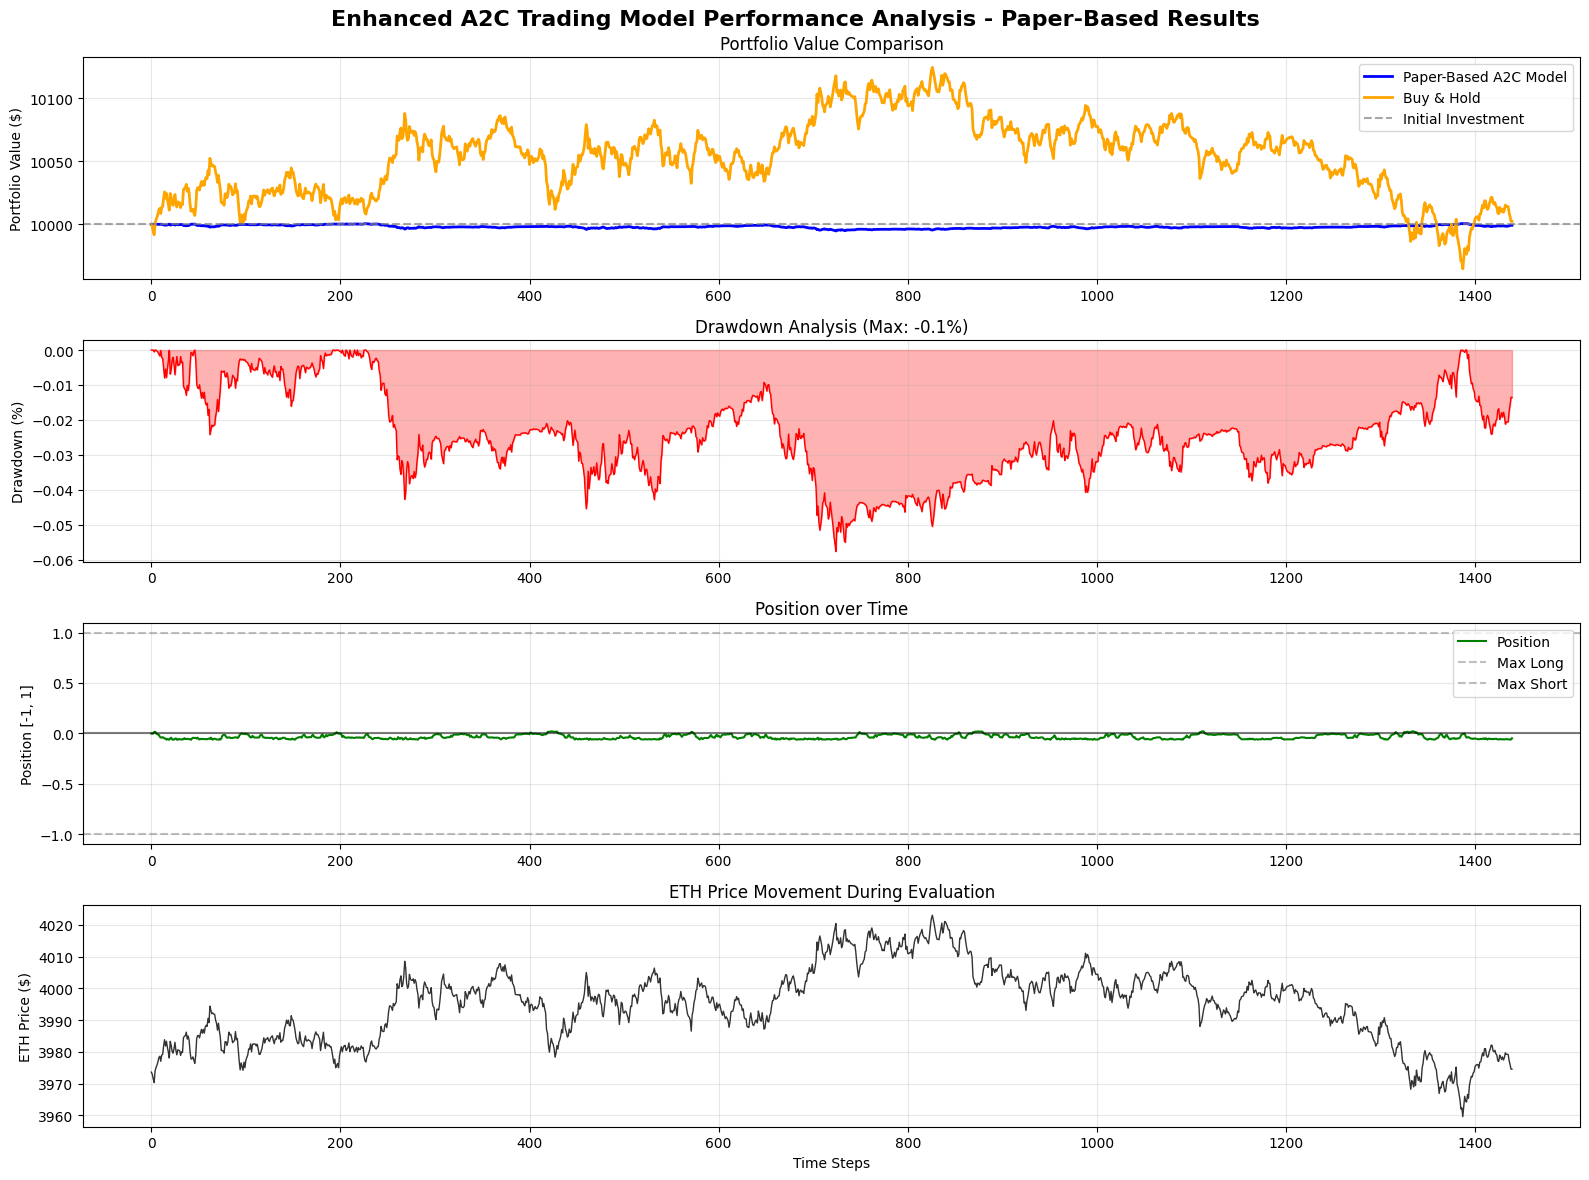

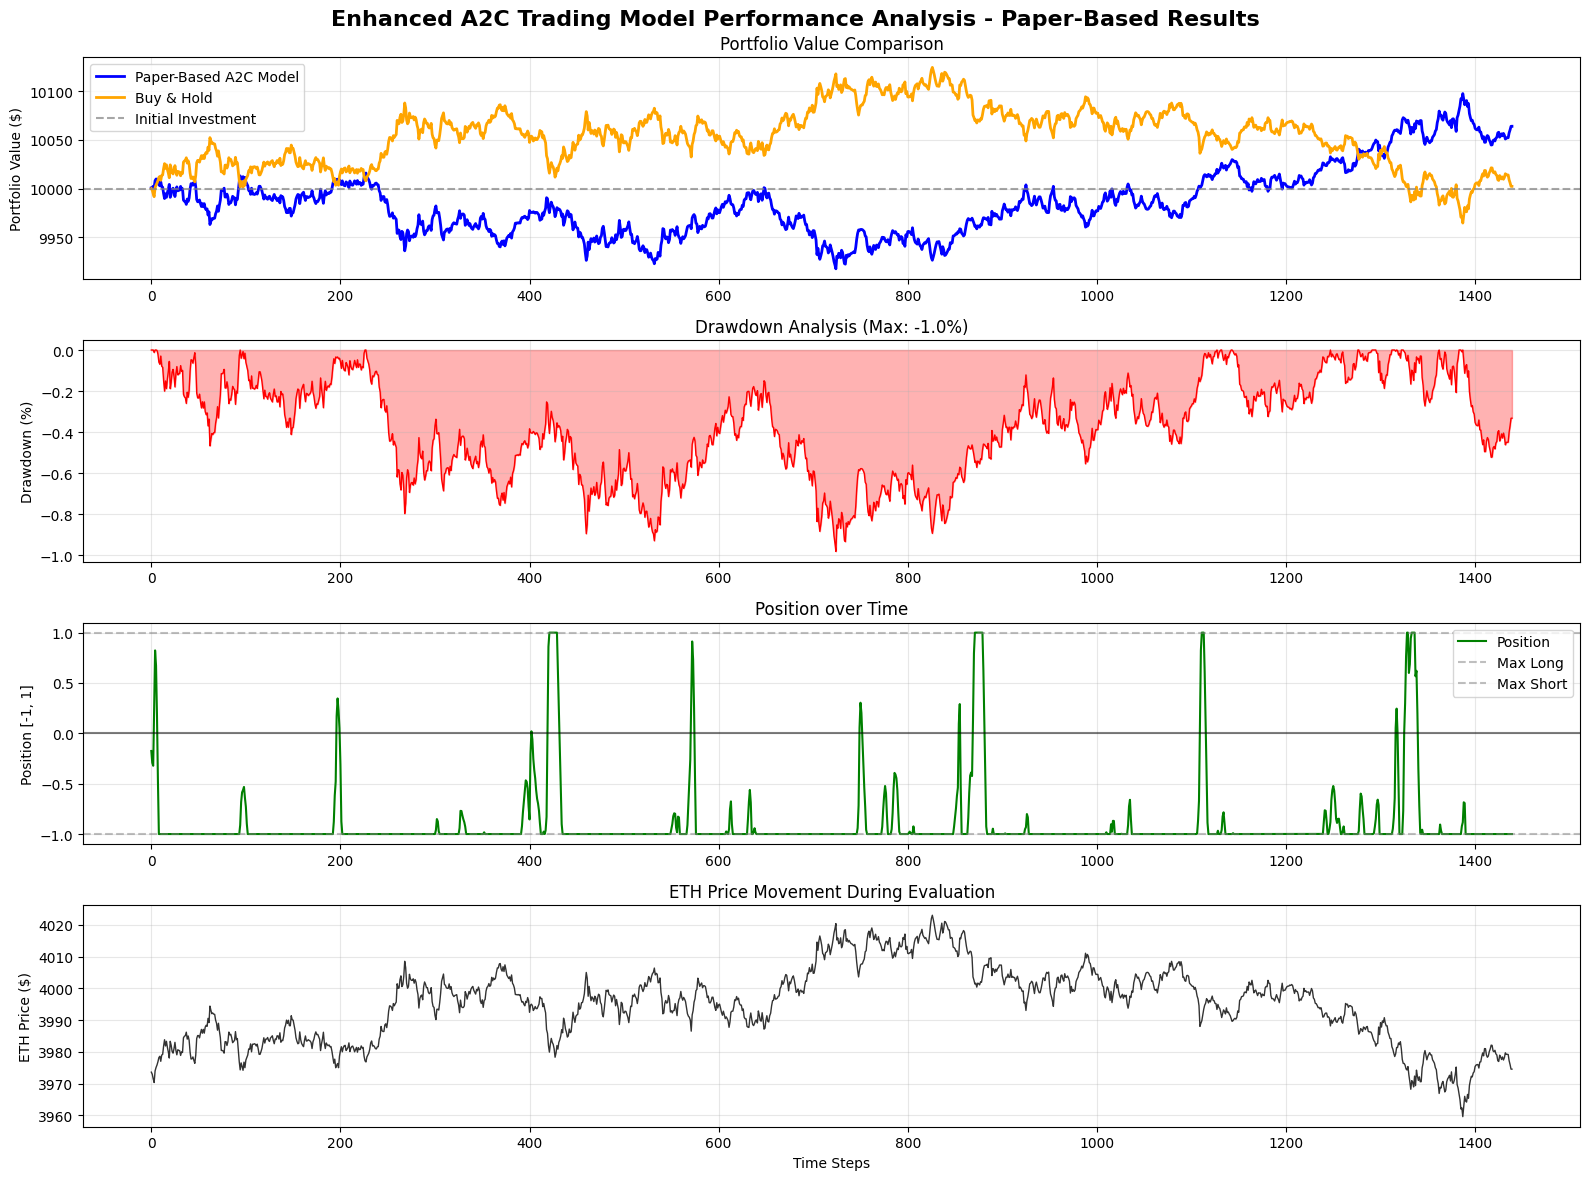

📊 Performance charts saved for top 2 models


In [9]:
# ===================== EVALUATE ALL TRAINED MODELS =====================
print("\n🎯 EVALUATING ALL TRAINED MODELS")
print("===============================")

# Load the training results from the JSON file to get successful models
import json
import glob

# Find the most recent training summary file
summary_files = glob.glob("batch_training_summary_*.json")
if summary_files:
    latest_summary = max(summary_files)
    print(f"📁 Loading training results from: {latest_summary}")
    
    with open(latest_summary, 'r') as f:
        training_results = json.load(f)
    
    successful_models = [r for r in training_results if r['status'] == 'success']
else:
    print("❌ No training summary found")
    successful_models = []

print(f"📊 Evaluating {len(successful_models)} successfully trained models")

all_evaluation_results = []

# Create test environment
test_env = DummyVecEnv([lambda: EnhancedTradingEnv(
    df=test_df,
    feat_cols=feat_cols_paper,
    episode_length=len(test_df)-max(MA_PERIOD, WINDOW_SIZE) - 1,
    randomize_start=False
)])

for i, result in enumerate(successful_models):
    config_name = result['name']
    model_path = result['model_path']
    
    print(f"\n📈 EVALUATING {i+1}/{len(successful_models)}: {config_name.upper()}")
    print("=" * 60)
    
    try:
        # Load the trained model
        model = A2C.load(model_path)
        
        # Run detailed evaluation
        detailed_episodes = evaluate_detailed_trading(model, test_env, num_episodes=1)
        
        if detailed_episodes and detailed_episodes[0]['portfolio_values']:
            episode_data = detailed_episodes[0]
            
            # Calculate metrics
            detailed_metrics = calculate_detailed_metrics(episode_data)
            
            # Store results
            evaluation_result = {
                'config_name': config_name,
                'model_path': model_path,
                'metrics': detailed_metrics,
                'episode_data': episode_data  # Store the complete episode data
            }
            
            all_evaluation_results.append(evaluation_result)
            
            print(f"   📊 METRICS SUMMARY:")
            print(f"      Final NAV: {detailed_metrics['FinalNAV']:.3f}")
            print(f"      Avg |Position|: {sum(abs(p) for p in episode_data['positions']) / len(episode_data['positions']):.3f}")
            print(f"      Trades: {detailed_metrics['Trades']}")
            print(f"      Sharpe: {detailed_metrics['Sharpe']:.3f}")
            
            # Status assessment
            avg_pos = sum(abs(p) for p in episode_data['positions']) / len(episode_data['positions'])
            if avg_pos < 0.5:
                status = "🟢 BALANCED - Static position problem SOLVED!"
            elif avg_pos < 0.7:
                status = "🟡 MODERATE - Partially solved"
            else:
                status = "🔴 STATIC - Still has position sticking"
            
            print(f"      Status: {status}")
            
        else:
            print(f"   ❌ Evaluation failed - no trading data")
            
    except Exception as e:
        print(f"   ❌ Evaluation error: {str(e)}")

# Create comparison summary
print(f"\n🏆 FINAL COMPARISON - ALL MODELS")
print("=" * 80)
print(f"{'Model':<20} {'NAV':<8} {'AvgPos':<8} {'Trades':<8} {'Sharpe':<8} {'Status':<15}")
print("-" * 80)

# Sort by average position (key metric for static position fix)
if all_evaluation_results:
    # Calculate avg_abs_position for sorting
    for result in all_evaluation_results:
        if 'positions' in result['episode_data']:
            avg_abs_pos = sum(abs(p) for p in result['episode_data']['positions']) / len(result['episode_data']['positions'])
            result['avg_abs_position'] = avg_abs_pos
        else:
            result['avg_abs_position'] = float('inf')
    
    sorted_results = sorted(all_evaluation_results, key=lambda x: x['avg_abs_position'])

    for result in sorted_results:
        name = result['config_name'][:18]
        nav = f"{result['metrics']['FinalNAV']:.3f}"
        avg_pos = f"{result['avg_abs_position']:.3f}"
        trades = str(result['metrics']['Trades'])
        sharpe = f"{result['metrics']['Sharpe']:.2f}"
        
        if result['avg_abs_position'] < 0.5:
            status = "🟢 BALANCED"
        elif result['avg_abs_position'] < 0.7:
            status = "🟡 MODERATE"
        else:
            status = "🔴 STATIC"
        
        print(f"{name:<20} {nav:<8} {avg_pos:<8} {trades:<8} {sharpe:<8} {status:<15}")

# Save evaluation results
eval_file = f"batch_evaluation_results_{datetime.now().strftime('%Y%m%d_%H%M')}.json"
with open(eval_file, 'w') as f:
    json.dump(all_evaluation_results, f, indent=2, default=str)

print(f"\n💾 Evaluation results saved to: {eval_file}")
print(f"\n🎉 BATCH TRAINING AND EVALUATION COMPLETE!")

# Find best configurations and plot only the two best ones
if all_evaluation_results:
    best_balanced = min(all_evaluation_results, key=lambda x: x['avg_abs_position'])
    best_performance = max(all_evaluation_results, key=lambda x: x['metrics']['FinalNAV'])
    
    print(f"\n🎯 RECOMMENDATIONS:")
    print(f"   Most Balanced: {best_balanced['config_name']} (AvgPos: {best_balanced['avg_abs_position']:.3f})")
    print(f"   Best Performance: {best_performance['config_name']} (NAV: {best_performance['metrics']['FinalNAV']:.3f})")
    
    print(f"\n🎨 Creating performance charts for the two best models...")
    create_enhanced_trading_plots(best_balanced['episode_data'])
    create_enhanced_trading_plots(best_performance['episode_data'])
    print(f"📊 Performance charts saved for top 2 models")
else:
    print(f"\n⚠️  No successful evaluations to analyze")


🎯 EVALUATING SELECTED MODELS (20 episodes × 40320 minutes)
📁 Loading training results from: batch_training_summary_20250914_2030.json
📊 Evaluating 2 selected models: ultra_conservative_0030, ultra_conservative_0323
   🔧 Initializing ENHANCED environment with fundamental fixes...
      ✅ Enhanced environment ready with ALL fundamental fixes!
      🎯 Observation: (6,) (includes momentum indicators)

📈 EVALUATING 1/2: ULTRA_CONSERVATIVE_0030
📈 Running detailed trading analysis...
   Episode 1/20
      Steps: 40320, Final Value: $9,802.52, Return: -1.97%
   Episode 2/20
      Steps: 40320, Final Value: $9,911.84, Return: -0.88%
   Episode 3/20
      Steps: 40320, Final Value: $9,738.71, Return: -2.61%
   Episode 4/20
      Steps: 40320, Final Value: $9,959.95, Return: -0.40%
   Episode 5/20
      Steps: 40320, Final Value: $9,854.40, Return: -1.46%
   Episode 6/20
      Steps: 40320, Final Value: $9,947.13, Return: -0.53%
   Episode 7/20
      Steps: 40320, Final Value: $9,795.28, Return:

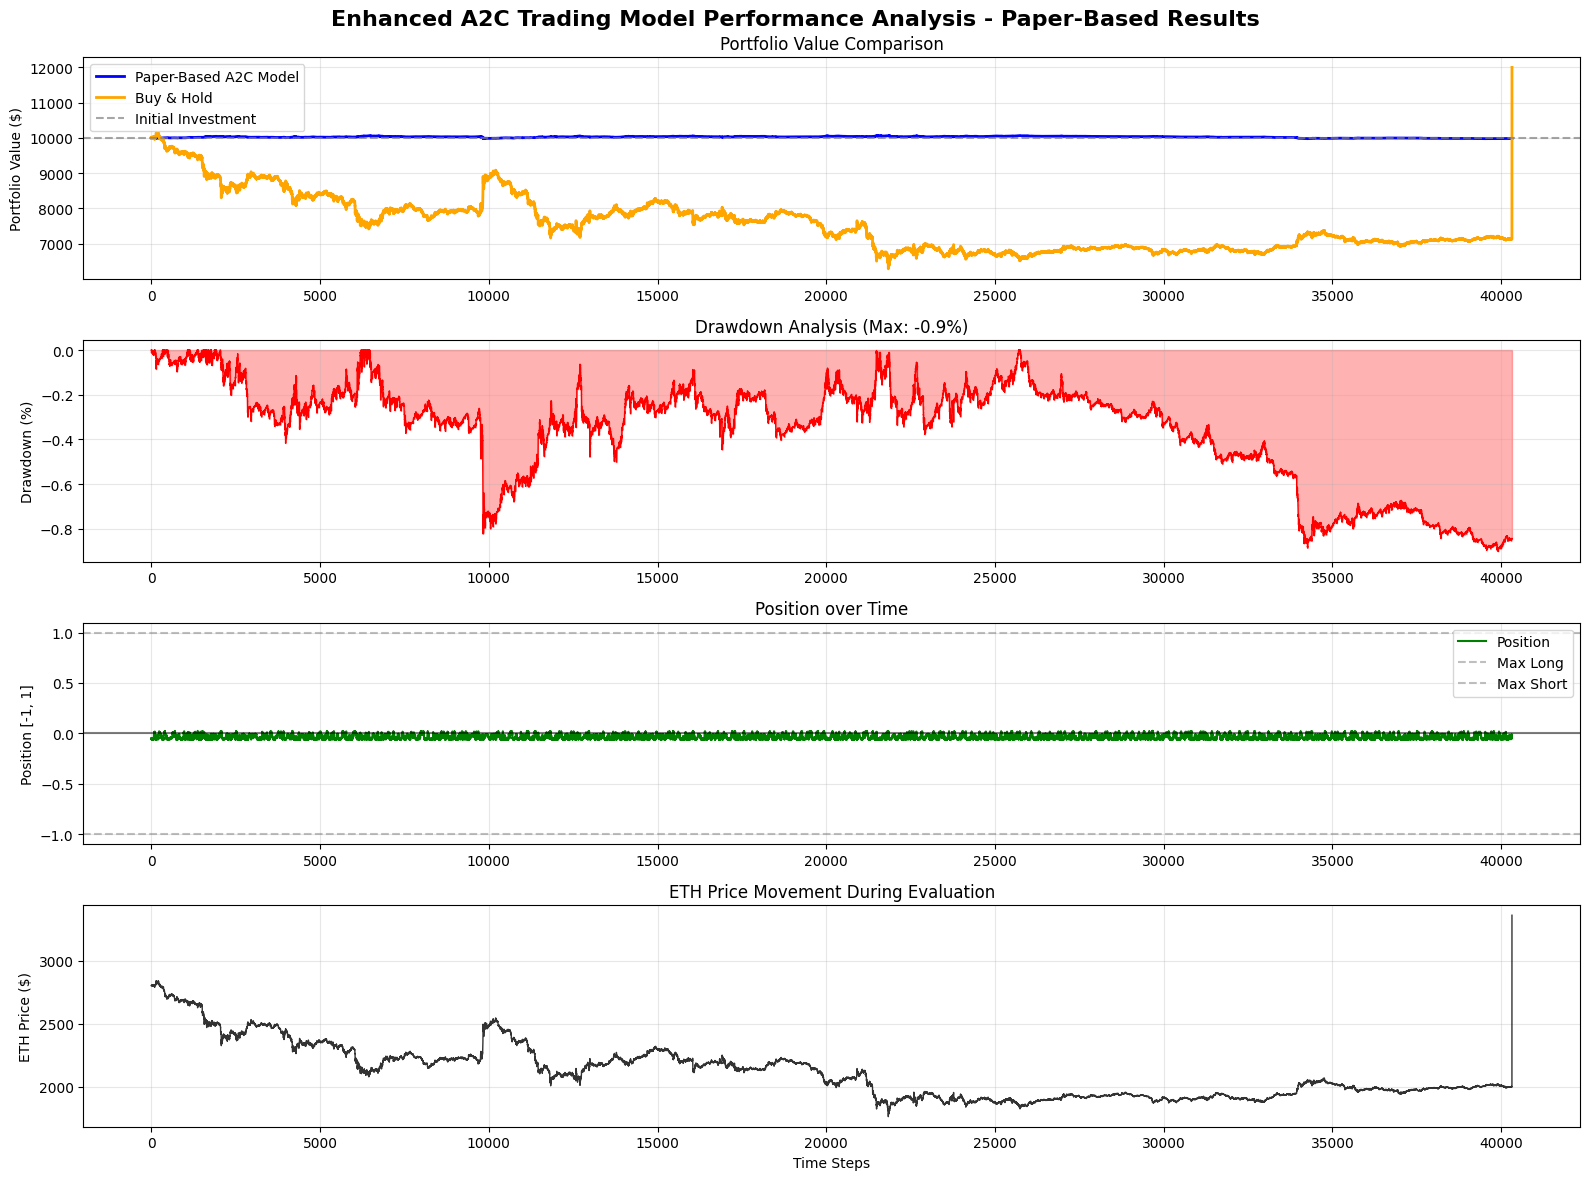

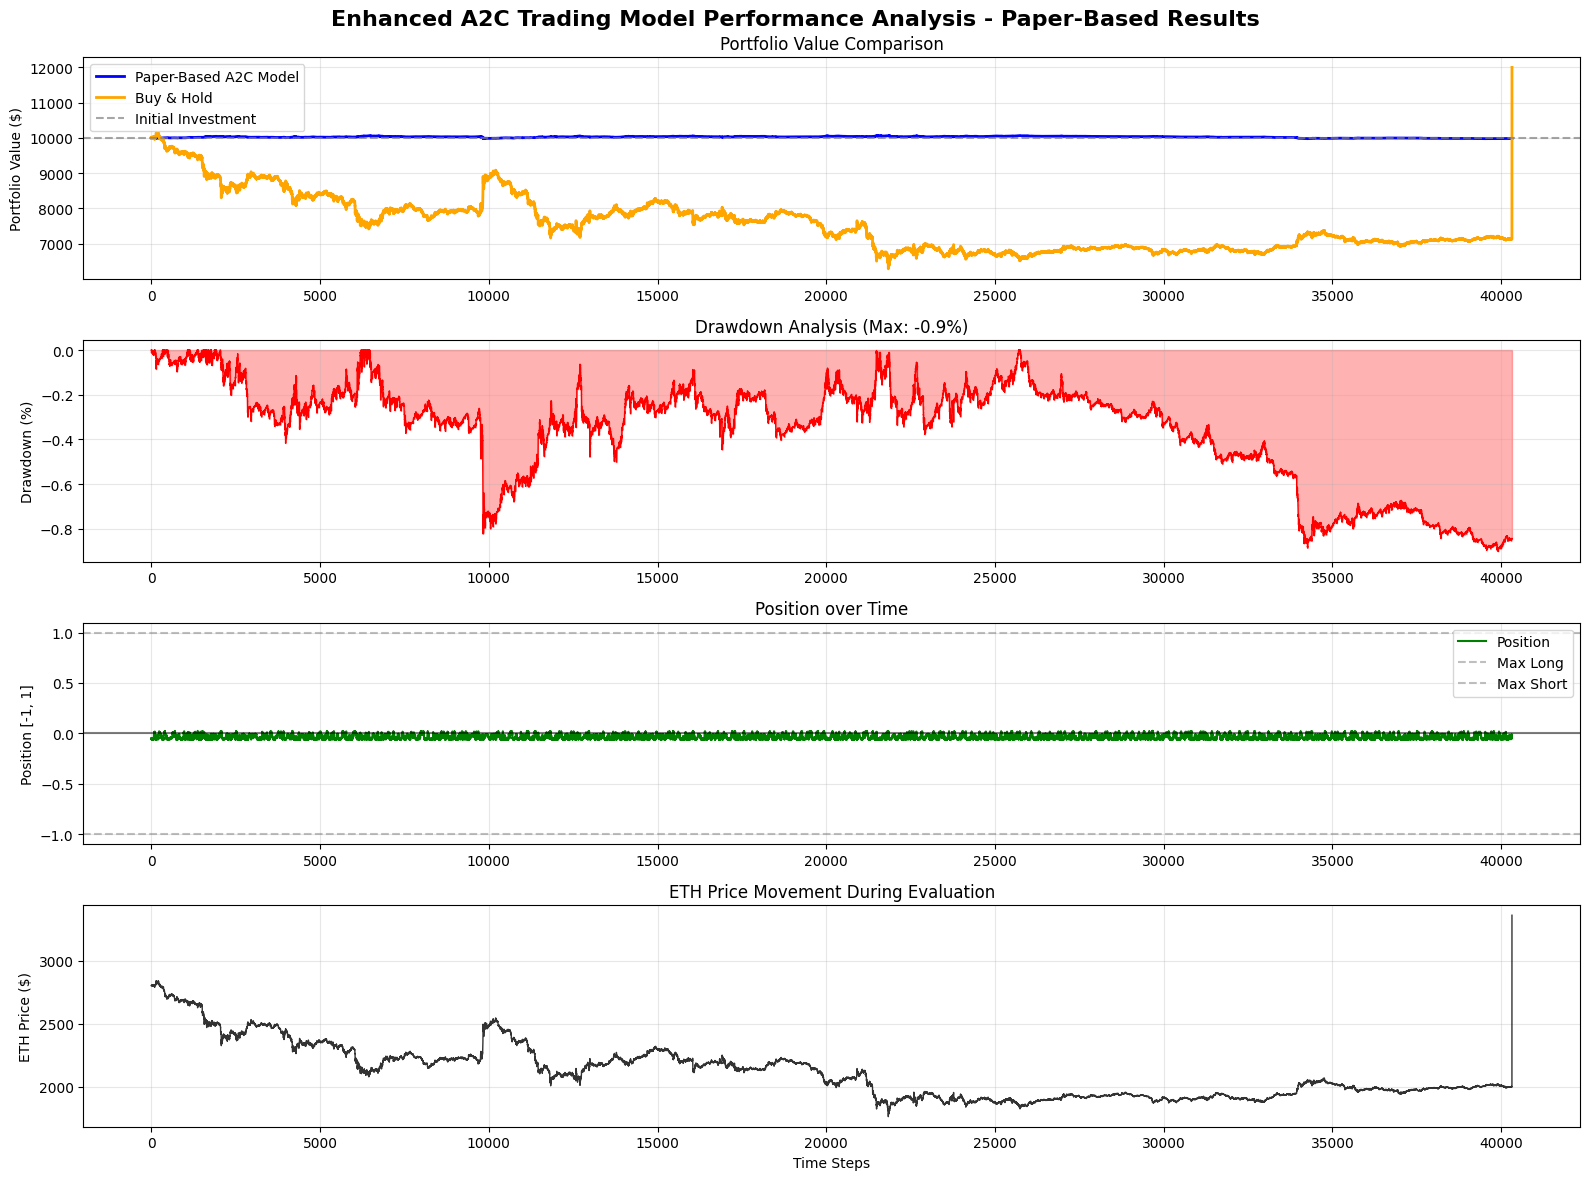

📊 Performance charts saved for selected models


In [10]:
from datetime import datetime
import json, glob
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv

# Config
SELECTED_MODELS = {"ultra_conservative_0030", "ultra_conservative_0323"}
NUM_EPISODES = 20
EPISODE_LENGTH_MIN = 40320  # 28 days at 1-minute bars
MIN_START = max(MA_PERIOD, WINDOW_SIZE)  # 120 in your setup

print("\n🎯 EVALUATING SELECTED MODELS (20 episodes × 40320 minutes)")
print("===========================================================")

# Load the most recent training summary and filter for the two configs
summary_files = glob.glob("batch_training_summary_*.json")
if summary_files:
    latest_summary = max(summary_files)
    print(f"📁 Loading training results from: {latest_summary}")
    with open(latest_summary, 'r') as f:
        training_results = json.load(f)
    successful_models = [r for r in training_results if r.get('status') == 'success']
else:
    print("❌ No training summary found")
    successful_models = []

# Keep only the two requested models (if present)
successful_models = [r for r in successful_models if r.get('name') in SELECTED_MODELS]
print(f"📊 Evaluating {len(successful_models)} selected models: {', '.join([r['name'] for r in successful_models]) or '(none)'}")

# Build a test env with 28-day episodes and randomized starts to cover the test set
test_env = DummyVecEnv([lambda: EnhancedTradingEnv(
    df=test_df,
    feat_cols=feat_cols_paper,
    episode_length=EPISODE_LENGTH_MIN,
    randomize_start=True
)])


def avg_abs_position(episode_data):
    if not episode_data['positions']:
        return 0.0
    return sum(abs(p) for p in episode_data['positions']) / len(episode_data['positions'])


all_evaluation_results = []

for i, result in enumerate(successful_models):
    config_name = result['name']
    model_path = result['model_path']

    print(f"\n📈 EVALUATING {i+1}/{len(successful_models)}: {config_name.upper()}")
    print("=" * 60)
    try:
        model = A2C.load(model_path)

        episodes = evaluate_detailed_trading(model, test_env, num_episodes=NUM_EPISODES, evalulation_in_minutes=EPISODE_LENGTH_MIN)

        # Compute per-episode metrics and aggregate
        per_ep_metrics = []
        per_ep_avg_pos = []
        for ep in episodes:
            if ep['portfolio_values']:
                metrics = calculate_detailed_metrics(ep)
                per_ep_metrics.append(metrics)
                per_ep_avg_pos.append(avg_abs_position(ep))

        if not per_ep_metrics:
            print("   ❌ Evaluation failed - no trading data")
            continue

        # Aggregate (means)
        def mean(lst, key): 
            vals = [m[key] for m in lst if key in m]
            return sum(vals) / len(vals) if vals else 0.0

        agg_metrics = {
            'FinalNAV': mean(per_ep_metrics, 'FinalNAV'),
            'FinalValue': mean(per_ep_metrics, 'FinalValue'),
            'TotalReturn': mean(per_ep_metrics, 'TotalReturn'),
            'CAGR': mean(per_ep_metrics, 'CAGR'),
            'Sharpe': mean(per_ep_metrics, 'Sharpe'),
            'MaxDD': mean(per_ep_metrics, 'MaxDD'),
            'Trades': int(round(mean(per_ep_metrics, 'Trades'))),
            'WinRate': mean(per_ep_metrics, 'WinRate'),
            'AvgWin': mean(per_ep_metrics, 'AvgWin'),
            'AvgLoss': mean(per_ep_metrics, 'AvgLoss'),
            'Episodes': len(per_ep_metrics)
        }

        avg_pos_mean = sum(per_ep_avg_pos) / len(per_ep_avg_pos)

        # Choose best episode (by FinalNAV) for plotting
        best_ep = max(zip(episodes, per_ep_metrics), key=lambda t: t[1]['FinalNAV'])[0]

        all_evaluation_results.append({
            'config_name': config_name,
            'model_path': model_path,
            'metrics': agg_metrics,
            'avg_abs_position': avg_pos_mean,
            'per_episode_metrics': per_ep_metrics,
            'episode_data': best_ep  # for plotting
        })

        print("   📊 METRICS SUMMARY (mean over episodes):")
        print(f"      Final NAV (mean): {agg_metrics['FinalNAV']:.3f}")
        print(f"      Avg |Position| (mean): {avg_pos_mean:.3f}")
        print(f"      Trades (mean): {agg_metrics['Trades']}")
        print(f"      Sharpe (mean): {agg_metrics['Sharpe']:.3f}")

        # Status assessment using averaged |position|
        if avg_pos_mean < 0.5:
            status = "🟢 BALANCED - Static position problem SOLVED!"
        elif avg_pos_mean < 0.7:
            status = "🟡 MODERATE - Partially solved"
        else:
            status = "🔴 STATIC - Still has position sticking"
        print(f"      Status: {status}")

    except Exception as e:
        print(f"   ❌ Evaluation error: {str(e)}")

# Comparison summary
print(f"\n🏆 FINAL COMPARISON - SELECTED MODELS")
print("=" * 80)
print(f"{'Model':<20} {'NAV(mean)':<10} {'AvgPos(mean)':<13} {'Trades(mean)':<13} {'Sharpe(mean)':<12} {'Status':<15}")
print("-" * 80)

if all_evaluation_results:
    sorted_results = sorted(all_evaluation_results, key=lambda x: x['avg_abs_position'])
    for r in sorted_results:
        name = r['config_name'][:18]
        nav = f"{r['metrics']['FinalNAV']:.3f}"
        avg_pos = f"{r['avg_abs_position']:.3f}"
        trades = str(r['metrics']['Trades'])
        sharpe = f"{r['metrics']['Sharpe']:.2f}"
        status = "🟢 BALANCED" if r['avg_abs_position'] < 0.5 else ("🟡 MODERATE" if r['avg_abs_position'] < 0.7 else "🔴 STATIC")
        print(f"{name:<20} {nav:<10} {avg_pos:<13} {trades:<13} {sharpe:<12} {status:<15}")

    # Save results
    eval_file = f"batch_evaluation_results_{datetime.now().strftime('%Y%m%d_%H%M')}.json"
    with open(eval_file, 'w') as f:
        json.dump(all_evaluation_results, f, indent=2, default=str)
    print(f"\n💾 Evaluation results saved to: {eval_file}")

    # Plot the two evaluated models (best-by-avg-pos and best-by-mean NAV)
    if all_evaluation_results:
        best_balanced = min(all_evaluation_results, key=lambda x: x['avg_abs_position'])
        best_performance = max(all_evaluation_results, key=lambda x: x['metrics']['FinalNAV'])

        print(f"\n🎯 RECOMMENDATIONS:")
        print(f"   Most Balanced: {best_balanced['config_name']} (AvgPos mean: {best_balanced['avg_abs_position']:.3f})")
        print(f"   Best Performance: {best_performance['config_name']} (NAV mean: {best_performance['metrics']['FinalNAV']:.3f})")

        print(f"\n🎨 Creating performance charts for the two selected models (best episode of each)...")
        create_enhanced_trading_plots(best_balanced['episode_data'])
        create_enhanced_trading_plots(best_performance['episode_data'])
        print("📊 Performance charts saved for selected models")
else:
    print("\n⚠️ No successful evaluations to analyze")
